In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import random

import xlwings as xw
import pymrmr
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axisartist.parasite_axes import SubplotHost
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import plot_roc_curve, auc, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from scipy import interp
from scipy.stats import pearsonr
from sklearn.manifold import TSNE

import torch
from torch import nn
from torch import optim

# import matlab.engine

# 1. Getting the data

In [7]:
filepath = r"data.xlsx"
wb = xw.Book(filepath)

In [8]:
def get_data():
    sheet = wb.sheets['dataset']
    df = sheet['A1:IY821'].options(pd.DataFrame, index=False, header=True).value
    
    # create meta df
    columns = df.iloc[4].values[1:]
    data = df.iloc[:2].values[:, 1:]
    index = df["index"].values[:2]
    meta = pd.DataFrame(data=data, index=index, columns=columns)

    # create data df
    data = df.iloc[5:].values[:, 1:]
    data = pd.DataFrame(data=data, columns=columns)
    
    return meta, data

In [9]:
def print_size(data):
    print("participant samples = ", data.shape[0])
    print("variables = ", data.shape[1])

In [10]:
meta, data = get_data()
print_size(data)

participant samples =  815
variables =  258


# 2. Preprocessing the data

In [11]:
def preprocess_data(meta, data, remove_missing=True):
    # set Case number as index
    data = data.set_index("Case")
    
    # remove Case, Drug Abuse Screening Test, Summary Variables, Diagnosis, and PHQ9 columns
    data = pd.concat([data.loc[:, "ReferralSource":"AUDIT_10"],
                      data.loc[:, "PCL_1":"Deploy_Exp30"],
                      data.loc[:, "Injuries_1a":"Injuries_2h"]], axis=1)
    meta = pd.concat([meta.loc[:, "ReferralSource":"AUDIT_10"],
                      meta.loc[:, "PCL_1":"Deploy_Exp30"],
                      meta.loc[:, "Injuries_1a":"Injuries_2h"]], axis=1)
    
    # remove participants samples without SI labels (PHQ_2i)
    mask = data["PHQ_2i"].isnull()
    data = data[~mask]
    
    # replace default values
    replacement = meta.loc["default values"]
    data = data.fillna(replacement)
    
    # store participant samples with no missing data
    mask = data != -1 
    complete_data = data[mask.all(axis=1)]

    # remove variables with more than 60 missing data points
    mask1 = meta.loc["default values"] == -1
    mask2 = meta.loc["missing samples"] >= 60
    excluded = [column for column in meta if mask1[column] and 
                                             mask2[column] and 
                                             column != "PHQ_2i"]
    data_excluded = data[excluded]
    data = data[[column for column in data if column not in excluded]]
    
    # separate labels from the data
    data = data.astype(int)
    labels = data["PHQ_2i"]
    data = data.drop("PHQ_2i", axis=1)

    labels = labels != 0 # True = have SI, False = does not have SI
    labels = labels.astype(int)
    
    if remove_missing:
        # remove participant samples with missing data
        mask = data != -1
        col_with_missing_values = data.columns[~mask.all(axis=0)].tolist()
        mask = mask.all(axis=1)
        data = data[mask]
        labels = labels[mask]
        return data, labels, col_with_missing_values
    
    return data, labels

In [12]:
full_data, full_labels = preprocess_data(meta, data, remove_missing=False)
data, labels, col_with_missing_values = preprocess_data(meta, data)

In [13]:
print_size(full_data)
print_size(data)

participant samples =  738
variables =  192
participant samples =  643
variables =  192


# 3. Reconstructing Data

In [14]:
def normalize_data(df):
    minmax = pd.DataFrame(columns=df.columns, index=["min", "max"])
    for column in df.columns:
        tmp = df[column].copy()
        df[column] = (tmp - tmp.min()) / (tmp.max() - tmp.min())
        minmax[column] = [tmp.min(), tmp.max()]
    return df, minmax

def denormalize_data(data, denorm_key):
    for column in data.columns:
        tmp = data[column]
        scale = denorm_key[column]
        data[column] = tmp * (scale.max() - scale.min()) + scale.min()
    return data

def dedummify_data(data):
    for feat in reversed(feature_options):
        idx_start = indices[feat]
        idx_end = idx_start + len(values[feat])
        record = data.iloc[:, idx_start:idx_end]
        result = np.argmax(record.values, axis=1) + 1

        data = data.drop(columns=record.columns)
        data.insert(idx_start, feat, result)
        
    return data

In [15]:
def get_onehot(record, feature):
    start_index = indices[feature]
    stop_index = start_index + len(values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    idx_max = np.argmax(onehot)
    return values[feature][idx_max]

def get_feature(record, feature):
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    return { f: get_feature(record, f) for f in feature_options }

def zero_out_feature(records, feature="RANDOM"):
    """ Set a feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    if feature == "RANDOM":
        feature = random.choice(feature_options)
        
    start_index = indices[feature]
    stop_index = start_index + len(values[feature])
    records[:, start_index:stop_index] = 0
    return records

In [16]:
def get_accuracy(model, data_loader):
    total = 0
    acc = 0
    for feat in feature_options:
        for batch in data_loader:
            inp = batch.detach().numpy()
            datam = zero_out_feature(batch.clone(), feat)
            
            if torch.cuda.is_available(): 
                datam = datam.cuda()
                out = model(datam).detach().cpu().numpy()
            else:
                out = model(datam).detach().numpy()
                
            for row in range(out.shape[0]):
                acc += int(get_feature(out[row], feat) == get_feature(inp[row], feat))
                total += 1
                
    return acc / total

In [17]:
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    for i, data in enumerate(loader):
        datam = zero_out_feature(data.clone())
        
        if torch.cuda.is_available(): 
            data = data.cuda()
            datam = datam.cuda()

        recon = net(datam)
        loss = criterion(recon, data)
        total_loss += loss.item()
    loss = float(total_loss) / (i + 1)
    return loss

In [18]:
def plot_training_curve(num_epochs, train_acc, val_acc, train_loss, val_loss):
    plt.title("Train vs Validation Accuracy")
    n = num_epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [19]:
"""
number of columns with missing data = 37 <- excluding age
number of participant samples without any missing data = 641
Aim for model to train (zero out) 40 features per epoch

batch size = 641 / 40 = 16.025
"""
best_val_acc = 0
best_model_param = None
def train_model(model, train_data, valid_data, batch_size=16, learning_rate=0.001, weight_decay=0, num_epochs=30):
    global best_val_acc, best_model_param
    torch.manual_seed(42)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        total_train_loss= 0.0
        for i, data in enumerate(train_loader):
            datam = zero_out_feature(data.clone())
            
            if torch.cuda.is_available():
                datam = datam.cuda()
                data = data.cuda()
                
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_train_loss += loss.item()

        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, valid_loader)
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_loss[epoch] = evaluate(model, valid_loader, criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   np.round(train_acc[epoch], 4),
                   np.round(train_loss[epoch], 4),
                   np.round(val_acc[epoch], 4),
                   np.round(val_loss[epoch], 4)))

        if val_acc[epoch] > best_val_acc:
            print("SAVING BEST MODEL")
            best_val_acc = val_acc[epoch]
            best_model_param = model.state_dict()

    plot_training_curve(num_epochs, train_acc, val_acc, train_loss, val_loss)

    return max(train_acc), max(val_acc)

In [20]:
data, labels, col_with_missing_values = preprocess_data(*get_data())

In [21]:
# wrong inputs by users (set the wrong inputs to "I don't know" option)
data["Pension"] = np.where(data["Pension"] == 8, 3, data["Pension"]) # set input of 8 to 3
data["Income"] = np.where(data["Income"] == 10, 7, data["Income"]) # set input of 10 to 7

# drop bad samples
data = data.drop(index=[2063, 1479])

In [22]:
feature_options = col_with_missing_values
# feature_options = data.columns.tolist()
feature_options.remove("Age_Intake") # not categorical (continuous). Also only 1 participant sample is missing age. 

In [23]:
data[feature_options] = data[feature_options].astype(str)
data = pd.get_dummies(data, prefix_sep='=')
data, denorm_key = normalize_data(data)

In [24]:
indices = {}  # Mapping of feature -> start index of feature in a record
values = {} # Mapping of feature -> list of categorical values the feature can take
for i, key in enumerate(data.keys()):
    if "=" in key: # categorical header
        feature, value = key.split("=")
        if feature not in indices:
            indices[feature] = i
            values[feature] = [value]
        else:
            values[feature].append(value)

In [25]:
print_size(data)

participant samples =  641
variables =  316


In [26]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(data.shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.Linear(128, data.shape[1])
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

NOTES:

What hyperparameter tuning I tried out:
    1. train only on columns with missing data (max validation accuracy 60%)
        - batch_size = 64, 32, *16, 8
        - hidden layers = (316, 64, 16), (316, 128, 64, 16), *(316, 128, 64), (316, 162, 64),
                          (316, 256, 128, 64), (316, 256, 128) {overfit}, (316, 128, 100, 64), (316, 128, 32)
                          (316, 200, 100) {overfit}, (316, 128, 64, 32)
        - learning_rate = 0.01, *0.001, 0.005, 0.0025, 0.0001, 
        - weight_decay = *0, 0.00001, 0.0001, 0.001 {much worse}
        
     * = IDEAL

In [ ]:
kf = KFold(n_splits=5)
train_accs = []
val_accs = []
for train_idxs, val_idxs in kf.split(data):
    train_data = data.iloc[train_idxs].values.astype(np.float32)
    valid_data = data.iloc[val_idxs].values.astype(np.float32)
    model = AutoEncoder()
    if torch.cuda.is_available(): model.cuda()
    train_acc, val_acc = train_model(model, train_data, valid_data)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

print("Median Validation Accuracy:", np.round(np.median(val_accs), 4), "±", np.round(np.std(val_accs), 4))
print("Median Training Accuracy:", np.round(np.median(train_accs), 4), "±", np.round(np.std(train_accs), 4))

In [ ]:
torch.save(best_model_param, "autoencoder")

## Check if model can overfit

In [ ]:
model = AutoEncoder()
test_df = data.sample(20)
test_inp = test_df.values.astype(np.float32)
_ = train_model(model, test_inp, test_inp, num_epochs=100)

In [ ]:
# actual data
dedummify_data(test_df)["SF36_11d"].head(n=10)

In [ ]:
# reconstructed data
recon_data = model(zero_out_feature(torch.tensor(test_df.values).float(), "SF36_11d"))
dedummify_data(pd.DataFrame(data=recon_data.detach().numpy(),
                            columns=test_df.columns,
                            index=test_df.index))["SF36_11d"].head(n=10)

## Baseline Model

In [ ]:
data, _, _ = preprocess_data(*get_data())
mode = data.mode()

total = 0
acc = 0
for feat in feature_options:
    for row in range(data.shape[0]):
        acc += int(data[feat].iloc[row] == mode[feat].iloc[0])
        total += 1
print(acc/total)

## RESULT

In [27]:
model = AutoEncoder()
model.load_state_dict(torch.load("autoencoder"))

<All keys matched successfully>

In [28]:
df, _ = preprocess_data(*get_data(), remove_missing=False)
df = df.drop(index=[2063, 1479]) # drop bad samples
mask = df != -1

df[feature_options] = df[feature_options].astype(str)
df = df.replace(-1, np.nan).replace("-1", np.nan)
df = pd.get_dummies(df, prefix_sep='=')
df, denorm_key = normalize_data(df.copy())

df = df[~mask.all(axis=1)]

In [29]:
print_size(df)

participant samples =  95
variables =  316


In [30]:
inp = torch.tensor(df.values)
recon = model(inp.float()).detach().numpy()
df[df.columns] = recon
df = denormalize_data(df, denorm_key)
df = dedummify_data(df)
df = df[feature_options]

In [31]:
full_data.loc[df.index, feature_options] = df

# 4. Experiment with Random Forest, Support Vector Machine, mRMR

In [ ]:
# connect to MATLAB session to use MATLAB's mRMR function
engine = matlab.engine.start_matlab()

In [ ]:
def select_features(train_data, train_labels, method="mRMR", n_features=10):

    if method == "mRMR":
        ess_var_idx = engine.mrmr_mid_d(matlab.int8(train_data.values.tolist()), 
                                        matlab.int8(train_labels.values.tolist()), 
                                        50)
        ess_var_idx = np.array(ess_var_idx[0]).astype(int) - 1
        ess_var_idx = ess_var_idx.tolist()
        ess_var = train_data.iloc[:, ess_var_idx].columns.tolist()
    
    elif method == "RF":
        clf = RandomForestClassifier(n_estimators=100)
        clf.fit(train_data, train_labels)
        ess_var = train_data.columns[np.argsort(clf.feature_importances_ * -1)].tolist()
    
    else:
        raise ValueError("Feature selection method unknown: ", method)
    
    return ess_var[0:n_features]

In [38]:
def plot(tprs, mean_fpr, aucs, ax):
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    print("AUC = %0.2f ± %0.2f" % (mean_auc, std_auc))

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Validation using ROC")
    ax.legend(loc="lower right")

    plt.show()
    
    auc_score = "{}% ± {}".format(np.round(np.mean(aucs)*100,1), np.round(np.std(aucs)*100,1))
    return mean_tpr, auc_score

In [ ]:
def train_experiment(data, labels, n_features=10, feat_select_methods=["mRMR", "RF",None], model_type="RF"):

    for method in feat_select_methods:
        kf = KFold(n_splits=5)

        acc = []
        cms = []
        tprs = []
        aucs = []
        ess_vars = []
        mean_fpr = np.linspace(0, 1, 100)

        fig, ax = plt.subplots(figsize=(8,6))
        for i, (train_idxs, test_idxs) in enumerate(kf.split(data)):
            # separate dataset into training and testing
            training_data = data.iloc[train_idxs]
            training_labels = labels.iloc[train_idxs]
            testing_data = data.iloc[test_idxs]
            testing_labels = labels.iloc[test_idxs]

            # select features
            if method:
                ess_var = select_features(training_data, training_labels, method=method, n_features=n_features)
                training_data = training_data[ess_var]
                testing_data = testing_data[ess_var]
                print(ess_var)

            # train and test model
            if model_type == "RF":
                model = RandomForestClassifier(n_estimators=100)
            elif model_type == "SVM":
                model = svm.SVC(probability=True)
            else:
                raise ValueError("unknown model type:", model_type)
            model.fit(training_data, training_labels)
            prediction = model.predict_proba(testing_data)
            output = prediction[:, 1]
            output = np.array([1 if x > 0.5 else 0 for x in output]) # threshold = 0.5

            # compute results
            accuracy = 1 - sum(abs(output - testing_labels)) / len(output)
            cm = confusion_matrix(testing_labels, output)

            viz = plot_roc_curve(model, testing_data, testing_labels,
                                 name='ROC fold {}'.format(i + 1),
                                 alpha=0.3, lw=1, ax=ax)
            interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0

            acc.append(accuracy)
            cms.append(cm)
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        mean_cm = np.mean(np.array(cms), axis=0)
        tn, fp, fn, tp = mean_cm.ravel()
        print("Set of Selected Variables =")
        print("Mean Sensitivity = ", np.round(tp / (fn + tp), 4))
        print("Mean Specificity = ", np.round(tn / (tn + fp), 4))
        print("Mean Accuracy = ", np.round(np.mean(acc), 4))
        print("Mean AUC =", np.mean(aucs), "±", np.std(aucs))
        return plot(tprs, mean_fpr, aucs, ax)

In [ ]:
mean_tpr1, auc_score1 = train_experiment(full_data, full_labels, 25, feat_select_methods=[None])
mean_tpr2, auc_score2 = train_experiment(full_data, full_labels, 10, feat_select_methods=[None])

In [ ]:
data, labels, col_with_missing_values = preprocess_data(*get_data())
mean_tpr3, auc_score3 = train_experiment(data, labels, 25, feat_select_methods=["RF"])
mean_tpr4, auc_score4 = train_experiment(data, labels, 10, feat_select_methods=["RF"])

In [ ]:
mean_tpr5, auc_score5 = train_experiment(data, labels, feat_select_methods=[None])

In [ ]:
plt.plot(np.linspace(0, 1, 100), mean_tpr1, label="25 variables (n = 738)  (AUC = {})".format(auc_score1))
plt.plot(np.linspace(0, 1, 100), mean_tpr2, label="10 variables (n = 738)  (AUC = {})".format(auc_score2))
plt.plot(np.linspace(0, 1, 100), mean_tpr3, label="25 variables (n = 643)  (AUC = {})".format(auc_score3))
plt.plot(np.linspace(0, 1, 100), mean_tpr4, label="10 variables (n = 643)  (AUC = {})".format(auc_score4))
plt.plot(np.linspace(0, 1, 100), mean_tpr5, label="All 192 variables (n = 643)  (AUC = {})".format(auc_score5))
plt.xlabel('1 - specificity')
plt.ylabel('sensitivity')
plt.title('Validation using ROC')
plt.legend(loc='lower right')
plt.show()

## 4.5 Correlation of non-overlapping features selected by mRMR and RF

In [ ]:
# obtained from the results from 4. Training Random Forest/Support Vector Machine
mRMR_selected_feats = ['Afghanistan', 'Deploy_Exp23', 'Nondeployed', 'PCL_12', 'PCL_3', 'PHQ_1j', 'PHQ_2b', 'PHQ_2c', 
                       'PHQ_2f', 'PHQ_3a', 'PHQ_3b', 'PHQ_4f', 'PHQ_4g', 'PHQ_4h', 'PHQ_6d', 'PHQ_6h', 'PHQ_6j', 'PHQ_8', 
                       'PHQ_9', 'Pension', 'SF36_5a', 'SF36_5c', 'SF36_9c']
RF_selected_feats = ['AUDIT_1', 'Age_Intake', 'PCL_11', 'PCL_12', 'PCL_14', 'PCL_15', 'PCL_3', 'PCL_5', 
                     'PHQ_2b', 'PHQ_2c', 'PHQ_2e', 'PHQ_2f', 'PHQ_2g', 'PHQ_6h', 'PHQ_6j', 'SF36_9b', 'SF36_9c', 'SF36_9f']

In [ ]:
intersection = set(mRMR_selected_feats).intersection(RF_selected_feats)
intersection

In [ ]:
for feat in intersection:
    mRMR_selected_feats.remove(feat)
    RF_selected_feats.remove(feat)

In [ ]:
pearson_matrix = pd.DataFrame(columns=[["Random Forest",]*len(RF_selected_feats), RF_selected_feats], 
                              index=[["mRMR",]*len(mRMR_selected_feats), mRMR_selected_feats]).astype('float')
for x in mRMR_selected_feats:
    for y in RF_selected_feats:
        corr, prob = pearsonr(data[x], data[y])
        pearson_matrix.loc[("mRMR", x), ("Random Forest", y)] = corr

In [ ]:
pearson_matrix.style.background_gradient(cmap='Greens')

In [ ]:
def color_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val else 'black'
    return 'color: %s' % color
df = pearson_matrix > 0.35
df.style.applymap(color_red)

# 5 Training with Random Forest - Final

In [35]:
def print_performance(name, arr):
    print("Mean", name, "=", np.round(np.mean(arr), 4), "±", np.round(np.std(arr), 4))

In [36]:
def train_final(data, labels):
    kf = KFold(n_splits=5)

    acc = []
    cms = []
    tprs = []
    aucs = []
    ess_vars = []
    var_scores = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(8,6))
    for i, (train_idxs, test_idxs) in enumerate(kf.split(data)):
        # separate dataset into training and testing
        training_data = data.iloc[train_idxs]
        training_labels = labels.iloc[train_idxs]
        testing_data = data.iloc[test_idxs]
        testing_labels = labels.iloc[test_idxs]

        # train and test model
        model = RandomForestClassifier(n_estimators=100)
        model.fit(training_data, training_labels)
        prediction = model.predict_proba(testing_data)
        output = prediction[:, 1]
        output = np.array([1 if x > 0.5 else 0 for x in output]) # threshold = 0.5
        
        var_score = model.feature_importances_
        ess_var = data.columns[np.argsort(var_score * -1)].tolist()[0:25]
        ess_vars.append(ess_var)
        var_scores.append(var_score)
        
        # compute results
        accuracy = 1 - sum(abs(output - testing_labels)) / len(output)
        cm = confusion_matrix(testing_labels, output)

        viz = plot_roc_curve(model, testing_data, testing_labels,
                             name='ROC fold {}'.format(i + 1),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0

        acc.append(accuracy)
        cms.append(cm)
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # top variables based on weighted summation
    var_scores = np.array(var_scores).sum(axis=0)
    top_vars = data.columns[np.argsort(var_scores * -1)].tolist()[0:25]
    
    # performance results
    sens = []
    spec = []
    for cm in cms:
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (fn + tp)
        specificity = tn / (tn + fp)
        sens.append(sensitivity)
        spec.append(specificity)
    print_performance("Sensitivity", sens)
    print_performance("Specificity", spec)
    print_performance("Accuracy", acc)
    print_performance("AUC", aucs)
    return plot(tprs, mean_fpr, aucs, ax), ess_vars, top_vars

Mean Sensitivity = 0.7536 ± 0.0837
Mean Specificity = 0.7872 ± 0.0446
Mean Accuracy = 0.7696 ± 0.0525
Mean AUC = 0.8254 ± 0.0574
AUC = 0.82 ± 0.06


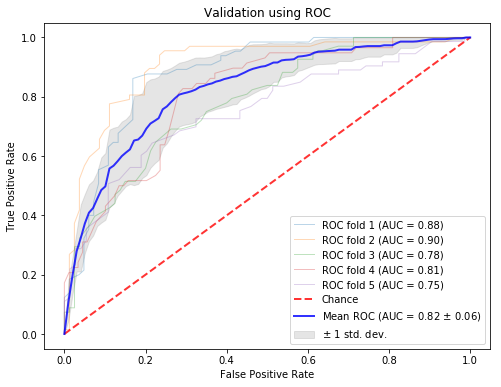

In [51]:
(mean_tpr1, auc_score1), ess_vars, top_vars = train_final(full_data, full_labels)

Mean Sensitivity = 0.7112 ± 0.0885
Mean Specificity = 0.7508 ± 0.0655
Mean Accuracy = 0.7293 ± 0.0604
Mean AUC = 0.8097 ± 0.0607
AUC = 0.81 ± 0.06


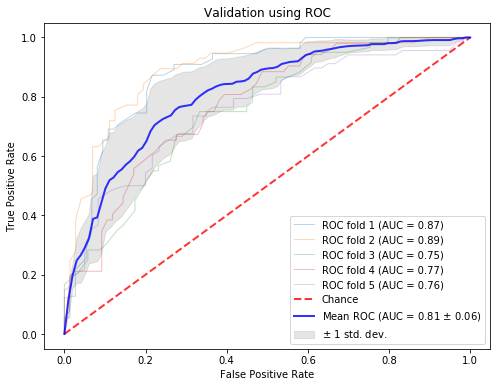

In [73]:
data, labels, col_with_missing_values = preprocess_data(*get_data())
(mean_tpr2, auc_score2), _, top_vars2 = train_final(data, labels)

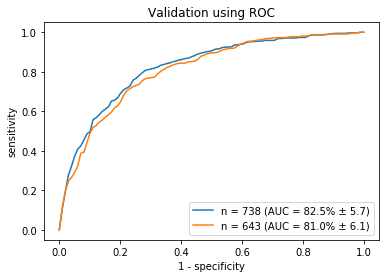

In [74]:
plt.plot(np.linspace(0, 1, 100), mean_tpr1, label="n = 738 (AUC = {})".format(auc_score1))
plt.plot(np.linspace(0, 1, 100), mean_tpr2, label="n = 643 (AUC = {})".format(auc_score2))
plt.xlabel('1 - specificity')
plt.ylabel('sensitivity')
plt.title('Validation using ROC')
plt.legend(loc='lower right')
plt.show()

In [75]:
top_vars[0:10]

['PCL_12',
 'PHQ_2f',
 'PHQ_2b',
 'SF36_9c',
 'PHQ_2g',
 'SF36_9f',
 'Age_Intake',
 'PCL_3',
 'PCL_15',
 'PCL_11']

In [76]:
top_vars2[0:10]

['PCL_12',
 'PHQ_2f',
 'SF36_9c',
 'PHQ_2b',
 'SF36_9f',
 'PHQ_2g',
 'PCL_11',
 'Age_Intake',
 'PHQ_2e',
 'PCL_10']

# 6 Essential Variables

In [32]:
# top_ten = top_vars[0:10]
top_ten = ['PCL_12', 'PHQ_2f','PHQ_2b','SF36_9f','SF36_9c','PHQ_2g','Age_Intake','PCL_11','PCL_14','PCL_3']

In [28]:
# find most common responses for the top 10 variables
not_SI = full_data[full_labels == 0]
SI = full_data[full_labels == 1]
responses = []
for var in top_ten:
    responses.append([not_SI[var].mode()[0], SI[var].mode()[0]])
pd.DataFrame(responses, columns=["SI not present", "SI present"], index=top_ten)

,SI not present,SI present
PCL_12,1,4
PHQ_2f,1,3
PHQ_2b,1,3
SF36_9f,4,2
SF36_9c,4,2
PHQ_2g,1,3
Age_Intake,43,46
PCL_11,1,5
PCL_14,4,5
PCL_3,1,4


In [29]:
# Age intake is kinda useless when showing just a single value, better to show a range
for idx, tmp in enumerate([SI, not_SI]):
    age_map = {"86 ~ 95": 0, "76 ~ 85": 0, "66 ~ 75": 0, "56 ~ 65": 0, "46 ~ 55": 0, "36 ~ 45": 0, "26 ~ 35": 0, "18 ~ 25": 0}
    for age, freq in tmp["Age_Intake"].value_counts().items():
        if  86 <= age <= 95: age_map["86 ~ 95"] += freq
        elif 76 <= age <= 85: age_map["76 ~ 85"] += freq
        elif 66 <= age <= 75: age_map["66 ~ 75"] += freq
        elif 56 <= age <= 65: age_map["56 ~ 65"] += freq
        elif 46 <= age <= 55: age_map["46 ~ 55"] += freq
        elif 36 <= age <= 45: age_map["36 ~ 45"] += freq
        elif 26 <= age <= 35: age_map["26 ~ 35"] += freq
        elif 18 <= age <= 25: age_map["18 ~ 25"] += freq
    if idx == 0: print("SI present \n", age_map)
    else: print("SI not present \n", age_map)

SI present 
 {'86 ~ 95': 1, '76 ~ 85': 6, '66 ~ 75': 13, '56 ~ 65': 37, '46 ~ 55': 110, '36 ~ 45': 84, '26 ~ 35': 66, '18 ~ 25': 14}
SI not present 
 {'86 ~ 95': 2, '76 ~ 85': 18, '66 ~ 75': 16, '56 ~ 65': 37, '46 ~ 55': 90, '36 ~ 45': 117, '26 ~ 35': 91, '18 ~ 25': 35}


In [33]:
tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(full_data[top_ten])
tsne_df = pd.DataFrame(tsne_results, columns=["tsne-2d-one", "tsne-2d-two"], index=full_data.index)
tsne_df["label"] = full_labels.replace(0, "not SI").replace(1, "SI")

# https://stackoverflow.com/questions/22294241/plotting-a-decision-boundary-separating-2-classes-using-matplotlibs-pyplot
clf = svm.SVC()
clf.fit(tsne_results, full_labels)
h = 0.02
x_min, x_max = tsne_results[:, 0].min() - 1, tsne_results[:, 0].max() + 1
y_min, y_max = tsne_results[:, 1].min() - 1, tsne_results[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

In [35]:
clf.score(tsne_results, full_labels)

0.7384823848238482

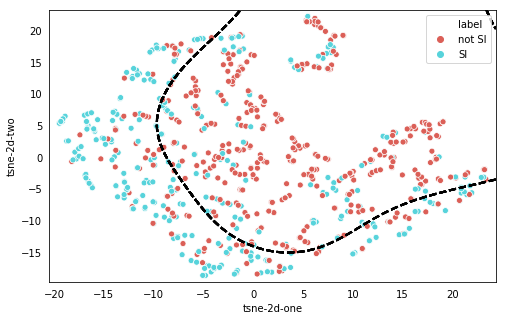

In [34]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=tsne_df,
    legend="full"
)
plt.contour(xx, yy, Z, colors="black", linewidths=2.0, linestyles="dashed")
plt.tick_params(axis='both', which='both', bottom=False, left=False)

In [48]:
other_var = [column for column in full_data.columns if column not in top_ten]

In [31]:
pearson_matrix = pd.DataFrame(columns=other_var, index=top_ten).astype('float')
for x in top_ten:
    for y in other_var:
        corr, prob = pearsonr(full_data[x], full_data[y])
        pearson_matrix.loc[x, y] = np.round(corr,3)

In [32]:
print("There is", pearson_matrix.size - (abs(pearson_matrix) > 0.5).replace(True, np.nan).count().sum(),
      "out of", pearson_matrix.size,"variable pairs that had correlation values lie between [0.5, 0.1] and [-0.5, -1.0]")

There is 41 out of 1820 variable pairs that had correlation values lie between [0.5, 0.1] and [-0.5, -1.0]


In [33]:
pearson_matrix["PHQ_2a"]

PCL_12        0.453
PHQ_2f        0.554
PHQ_2b        0.711
SF36_9f      -0.540
SF36_9c      -0.551
PHQ_2g        0.555
Age_Intake   -0.017
PCL_11        0.507
PCL_14        0.413
PCL_3         0.349
Name: PHQ_2a, dtype: float64

In [121]:
# correlation visual: 1
high_corr_var = []
for var in other_var:
    if (abs(pearson_matrix[var]) > 0.5).any():
        high_corr_var.append(var)
pearson_matrix[high_corr_var].style.background_gradient(cmap='Greens')

,SF36_6,SF36_9g,SF36_9h,SF36_9i,SF36_10,PHQ_1n,PHQ_2a,PHQ_2d,PHQ_2e,PHQ_5f,PHQ_5g,PCL_1,PCL_2,PCL_4,PCL_5,PCL_6,PCL_7,PCL_9,PCL_10,PCL_15,PCL_16
PCL_12,0.388,-0.349,0.37,-0.289,-0.447,0.411,0.453,0.355,0.387,0.393,0.327,0.364,0.332,0.415,0.396,0.368,0.367,0.517,0.547,0.534,0.399
PHQ_2f,0.483,-0.41,0.448,-0.335,-0.515,0.456,0.554,0.452,0.514,0.419,0.388,0.336,0.281,0.367,0.32,0.307,0.346,0.497,0.492,0.494,0.314
PHQ_2b,0.509,-0.452,0.519,-0.433,-0.573,0.391,0.711,0.553,0.466,0.458,0.392,0.373,0.293,0.429,0.396,0.303,0.314,0.579,0.557,0.483,0.331
SF36_9f,-0.498,0.629,-0.51,0.516,0.538,-0.41,-0.54,-0.471,-0.408,-0.387,-0.334,-0.307,-0.279,-0.371,-0.353,-0.279,-0.316,-0.489,-0.475,-0.447,-0.295
SF36_9c,-0.501,0.524,-0.475,0.489,0.54,-0.382,-0.551,-0.455,-0.408,-0.391,-0.334,-0.288,-0.268,-0.356,-0.325,-0.273,-0.295,-0.478,-0.456,-0.443,-0.28
PHQ_2g,0.427,-0.381,0.421,-0.312,-0.486,0.543,0.555,0.459,0.472,0.648,0.365,0.35,0.326,0.378,0.387,0.359,0.42,0.511,0.461,0.662,0.371
Age_Intake,-0.03,0.05,-0.055,0.055,0.042,-0.023,-0.017,0.046,-0.132,0.092,-0.047,0.048,0.017,-0.02,-0.016,-0.048,-0.016,-0.057,-0.199,-0.006,-0.127
PCL_11,0.427,-0.303,0.415,-0.223,-0.437,0.327,0.507,0.331,0.366,0.353,0.325,0.345,0.309,0.4,0.366,0.456,0.436,0.631,0.692,0.516,0.466
PCL_14,0.45,-0.304,0.38,-0.26,-0.399,0.342,0.413,0.335,0.329,0.372,0.534,0.407,0.346,0.466,0.431,0.4,0.385,0.5,0.535,0.606,0.477
PCL_3,0.341,-0.268,0.216,-0.19,-0.368,0.33,0.349,0.285,0.263,0.356,0.315,0.682,0.656,0.674,0.676,0.502,0.584,0.416,0.368,0.431,0.522


In [346]:
def get_xticks(var):
    xtick = []
    major_tick = [0]
    categories = ["Demographic", "SF36", "PHQ", "AUDIT", "PCL", "Deploy", "Injuries", "<END>"]
    count = start = 0
    for idx, var in enumerate(other_var):
        if categories[count+1] in var:
            mid = start + int((idx - start) / 2)
            xtick[mid] = "\n{}".format(categories[count])
            start = idx
            major_tick.append(start)
            count += 1
        xtick.append("")
    mid = start + int((idx - start) / 2)
    xtick[mid] = "\n{}".format(categories[count])
    major_tick.append(idx+1)
    return xtick, major_tick

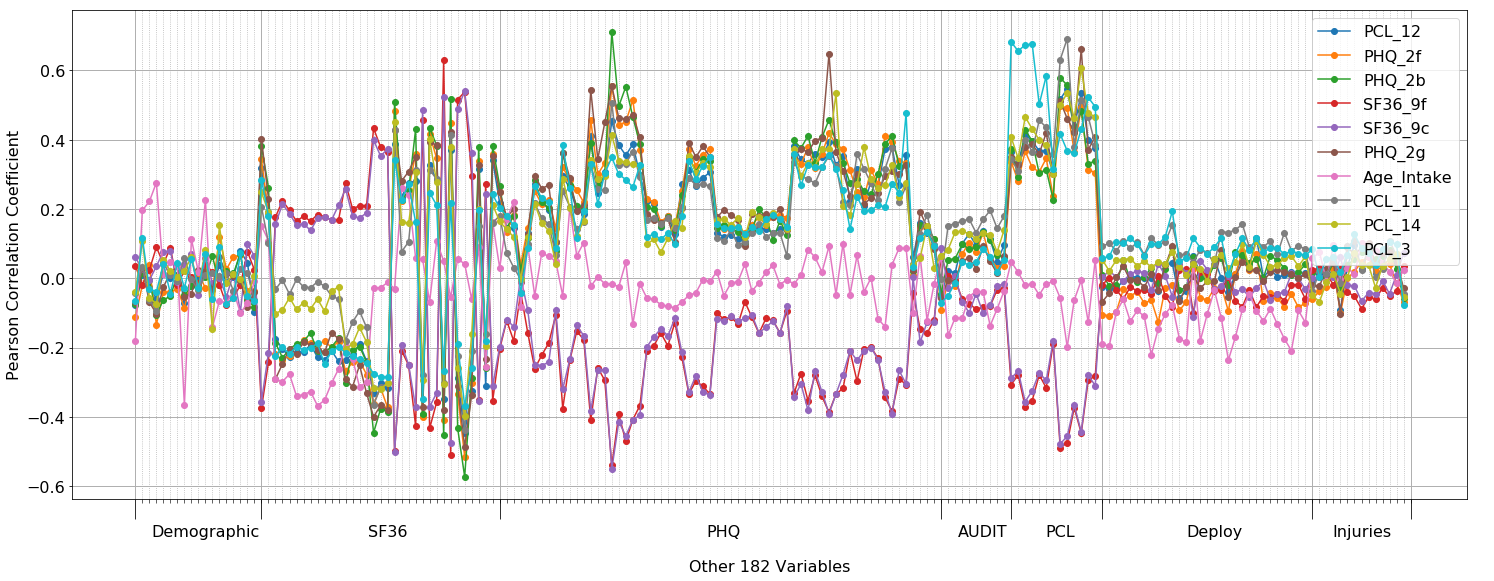

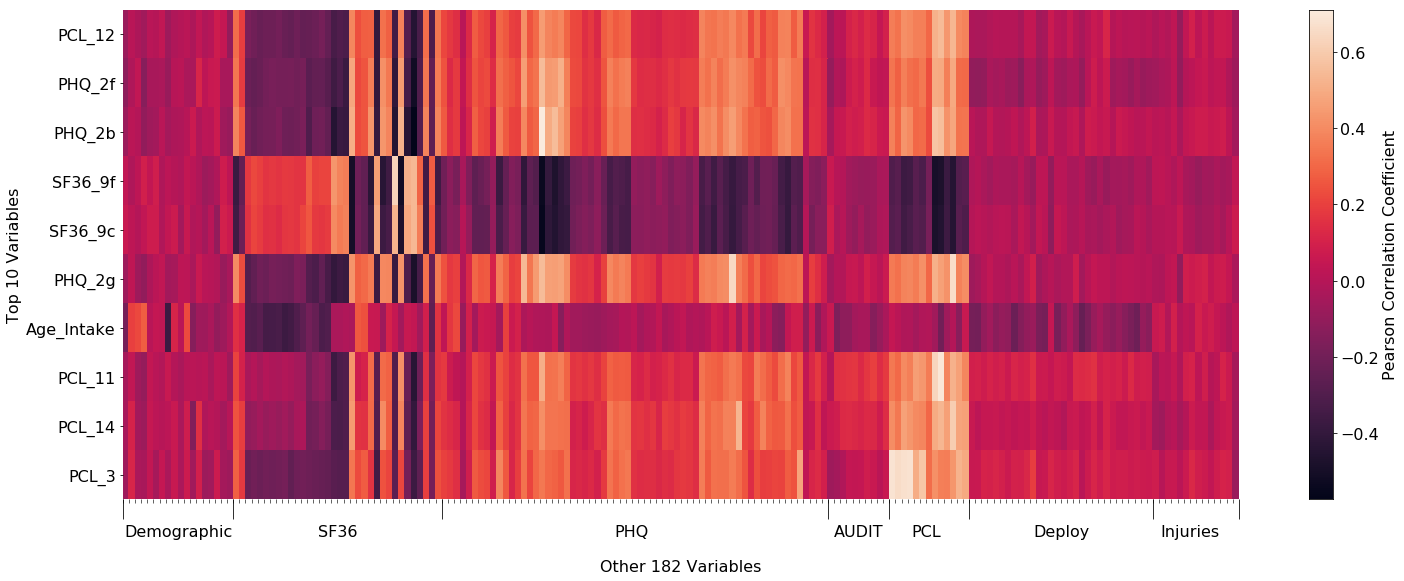

In [383]:
# calculate x-axis ticks
xtick, major_tick = get_xticks(other_var)

# line plot
fig, ax = plt.subplots(figsize=(25,9))
ax.plot(pearson_matrix.T, marker="o")
ax.set_xlabel("Other 182 Variables", fontsize=16, labelpad=20)
ax.set_ylabel("Pearson Correlation Coefficient", fontsize=16)
ax.grid(which='minor', linestyle=':', linewidth='0.8')
ax.grid(which='major', linestyle='-', linewidth='1.0')
ax.xaxis.set_minor_locator(plt.FixedLocator(np.arange(1, 183)))
ax.xaxis.set_minor_formatter(plt.FixedFormatter(xtick))
ax.xaxis.set_major_locator(plt.FixedLocator(major_tick))
ax.xaxis.set_major_formatter(plt.FixedFormatter(xtick))
ax.tick_params(axis='x', which='minor', length=4, labelsize=16)
ax.tick_params(axis='x', which='major', length=20, labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
ax.legend(top_ten, loc="upper right", fontsize=16)
plt.show()

fig = plt.figure(figsize=(25,9))
ax = sns.heatmap(pearson_matrix)
cbar = ax.figure.axes[-1]
cbar.set_ylabel("Pearson Correlation Coefficient", size=16)
cbar.tick_params(labelsize=16)
cbar.set_frame_on(True)
ax.set_xlabel("Other 182 Variables", fontsize=16, labelpad=20)
ax.set_ylabel("Top 10 Variables", fontsize=16)
ax.xaxis.set_minor_locator(plt.FixedLocator([x for x in range(len(other_var))]))
ax.xaxis.set_minor_formatter(plt.FixedFormatter(xtick))
ax.xaxis.set_major_locator(plt.FixedLocator(major_tick))
ax.xaxis.set_major_formatter(plt.FixedFormatter(xtick))
ax.yaxis.set_major_locator(plt.FixedLocator(np.arange(1, 11)-0.5)) # -0.5 is used to center the yticks
ax.yaxis.set_major_formatter(plt.FixedFormatter(top_ten))
ax.tick_params(axis='x', which='minor', length=4, labelsize=16)
ax.tick_params(axis='x', which='major', length=20, labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.show()